In [24]:
# Importamos las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from load_catbunny import load_set
from PIL import Image

In [25]:
# Cargamos los datasets
X_train, y_train = load_set("./cat-bunny/train-cat-rabbit/")
X_test, y_test = load_set("./cat-bunny/test-images/")
X_val, y_val = load_set("./cat-bunny/val-cat-rabbit/")

print("X_train: ", X_train.shape, "y_train: ", y_train.shape)
print("X_test: ", X_test.shape, "y_test: ", y_test.shape)
print("X_val: ", X_val.shape, "y_val: ", y_val.shape)

X_train:  (1600, 64, 64, 3) y_train:  (1600,)
X_test:  (15, 64, 64, 3) y_test:  (15,)
X_val:  (414, 64, 64, 3) y_val:  (414,)


In [26]:
def load_image(path):
    img = Image.open(path).convert("RGB")
    img = img.resize((64, 64))
    
    return np.array(img) / 255.0

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [28]:
class MLP(nn.Module):
    def __init__(self, input_size:int, layer_sizes:list):
        super(MLP, self).__init__()
        
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes)
        
        # Inicializar pesos y bias
        self.weights = nn.ParameterList()
        self.biases = nn.ParameterList()
        
        # ======== Primer Capa ==========
        W = nn.Parameter(torch.randn(input_size, layer_sizes[0]) * 0.01)
        b = nn.Parameter(torch.zeros(layer_sizes[0]))
        
        self.weights.append(W)
        self.biases.append(b)
        
        # ====== Capas Ocultas =====
        for i in range(1, self.num_layers):
            # El tamaño es la capa anterior (input) y el tamaño de salida (actual)
            W = nn.Parameter(torch.randn(layer_sizes[i-1], layer_sizes[i]) * 0.01)
            b = nn.Parameter(torch.zeros(layer_sizes[i]))
            
            self.weights.append(W)
            self.biases.append(b)
            
        # ====== Capa de salida =====
        W_out = nn.Parameter(torch.randn(layer_sizes[-1], 1) * 0.01)
        b_out = nn.Parameter(torch.zeros(1))
        
        self.weights.append(W_out)
        self.biases.append(b_out)
        
    
    def forward(self, x):
        if x.dim() > 2:
            x = x.view(x.size(0), -1)
        
        # Iteramos sobre las cpaas
        for i in range(self.num_layers):
            x = torch.matmul(x, self.weights[i]) + self.biases[i]
            x = torch.relu(x)
            
        # Capa de salida
        x = torch.matmul(x, self.weights[-1]) + self.biases[-1]
        x = torch.sigmoid(x)
        
        return x.squeeze()
        
        

In [29]:
def train_torch(model, train_loader, test_loader, criterion, optimizer, epochs, device=None, verbose=True):
    if not device:
        device = torch.device("cpu")
        model = model.to(device)
        # train_loader = train_loader.to(device)
        test_loader = test_loader.to(device)
        
    all_losses = []
    test_acc_values = []
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        
        for data, target, in train_loader:
            data, target = data.to(device), target.to(device).float()
            
            optimizer.zero_grad()
            y_pred = model(data)
            
            loss = criterion(y_pred, target[:, 0])
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            all_losses.append(total_loss)  
        # inner for
        
        avg_loss = total_loss / len(train_loader)
        
        with torch.no_grad():
            total = 0
            correct = 0
            for data, target in test_loader:
                data, target = data.to(device), target.to(device).float()
                y_pred = model(data)
                
                predictions = (y_pred >= 0.5).float()
                total += target.size(0)
                correct += (predictions == target).sum().item()
                
        test_acc = correct / total
        test_acc_values.append(test_acc)
            
        if verbose:
            print(f"[Epoca {epoch}] Train loss: {avg_loss:.5f}")
            
    return all_losses, test_acc_values             
    
        

In [30]:
# Utilizaremos nuestro dataset de gatos y conejos.
# Necesitamos estandarizar los datos
# Convertimos a tensores de PyTorch
# Aplanamos
X_trainPT = torch.tensor(X_train, dtype=torch.float32).view(X_train.shape[0], -1)
X_testPT = torch.tensor(X_test, dtype=torch.float32).view(X_test.shape[0], -1)
y_trainPT = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_testPT = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Creamos los DataLoader
train_dataset = TensorDataset(X_trainPT, y_trainPT)
test_dataset = TensorDataset(X_testPT, y_testPT)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=15, shuffle=True)

In [31]:
# Configuración
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Dispositivo: ", device)

# Neuronas de entrada
input_size = X_trainPT.shape[1]
# Cantidad de neuronas en hidden
layer_sizes = [64, 32] # 16 8 4 2 1

model = MLP(input_size, layer_sizes)
model.to(device)

Dispositivo:  cpu


MLP(
  (weights): ParameterList(
      (0): Parameter containing: [torch.float32 of size 12288x64]
      (1): Parameter containing: [torch.float32 of size 64x32]
      (2): Parameter containing: [torch.float32 of size 32x1]
  )
  (biases): ParameterList(
      (0): Parameter containing: [torch.float32 of size 64]
      (1): Parameter containing: [torch.float32 of size 32]
      (2): Parameter containing: [torch.float32 of size 1]
  )
)

In [32]:
total = 0
for param in model.parameters():
    num = param.numel()
    print(f"{param.__class__.__name__}: {num}")
    total += num
    
print("Total params: ", total)

Parameter: 786432
Parameter: 2048
Parameter: 32
Parameter: 64
Parameter: 32
Parameter: 1
Total params:  788609


In [33]:
# Definimos la funcion de pérdida y optimizador
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [34]:
# Entrenamos
num_epochs = 100
all_losses, test_acc_values = train_torch(model,
                                          train_loader,
                                          test_loader,
                                          criterion,
                                          optimizer,
                                          num_epochs,
                                          device,
                                          True)

[Epoca 0] Train loss: 0.69318
[Epoca 1] Train loss: 0.69314
[Epoca 2] Train loss: 0.69312
[Epoca 3] Train loss: 0.69311
[Epoca 4] Train loss: 0.69306
[Epoca 5] Train loss: 0.69303
[Epoca 6] Train loss: 0.69298
[Epoca 7] Train loss: 0.69293
[Epoca 8] Train loss: 0.69288
[Epoca 9] Train loss: 0.69280
[Epoca 10] Train loss: 0.69272
[Epoca 11] Train loss: 0.69262
[Epoca 12] Train loss: 0.69250
[Epoca 13] Train loss: 0.69232
[Epoca 14] Train loss: 0.69211
[Epoca 15] Train loss: 0.69180
[Epoca 16] Train loss: 0.69142
[Epoca 17] Train loss: 0.69092
[Epoca 18] Train loss: 0.69024
[Epoca 19] Train loss: 0.68935
[Epoca 20] Train loss: 0.68834
[Epoca 21] Train loss: 0.68695
[Epoca 22] Train loss: 0.68543
[Epoca 23] Train loss: 0.68327
[Epoca 24] Train loss: 0.68074
[Epoca 25] Train loss: 0.67718
[Epoca 26] Train loss: 0.67234
[Epoca 27] Train loss: 0.66594
[Epoca 28] Train loss: 0.65842
[Epoca 29] Train loss: 0.64935
[Epoca 30] Train loss: 0.63965
[Epoca 31] Train loss: 0.62709
[Epoca 32] Train l

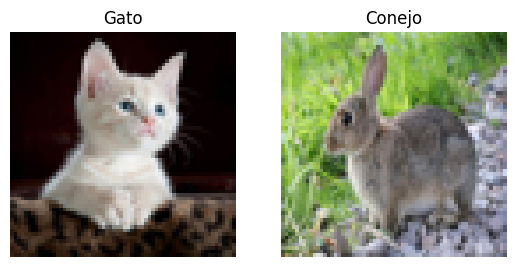

In [35]:
#
cat_img = load_image("./cat.jpg")
bun_img = load_image("./conejo.jpg")

plt.subplot(1, 2, 1)
plt.imshow(cat_img); plt.axis(False); plt.title("Gato")
plt.subplot(1, 2, 2)
plt.imshow(bun_img); plt.axis(False); plt.title("Conejo")
plt.show()

In [36]:
print("Cat shape: ", cat_img.shape)

Cat shape:  (64, 64, 3)


In [37]:
cat_imgT = torch.tensor(cat_img, dtype=torch.float32).unsqueeze(0)

cat_imgT.shape

torch.Size([1, 64, 64, 3])

In [38]:
bun_imgT = torch.tensor(bun_img, dtype=torch.float32).unsqueeze(0)

In [39]:
model.eval()

cat_label = model(cat_imgT.to(device)).detach().cpu().numpy()
bun_label = model(bun_imgT.to(device)).detach().cpu().numpy()

print(f"Predicción para el gato: {np.round(cat_label)}, Certeza: {cat_label}")
print(f"Predicción para el conejo: {np.round(bun_label)}, Certeza: {1-bun_label}")

Predicción para el gato: 1.0, Certeza: 0.525711178779602
Predicción para el conejo: 0.0, Certeza: 0.9624197483062744


----------------
## Keras

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation
from tensorflow.keras.optimizers import SGD

In [41]:
# Definimos el modelo
class PerceptronLayer(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(PerceptronLayer, self).__init__(**kwargs)
        self.units = units
        
    def build(self, input_shape):
        # Inicializamos los parámetros
        self.W = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True,
                                 name='W')
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True,
                                 name='b')
        super(PerceptronLayer, self).build(input_shape)
        
        
    def call(self, inputs):
        return tf.matmul(inputs, self.W) + self.b
    

# Construcción del modelo
def MLP_TF(input_size, layer_sizes):
    inputs = Input(shape=(input_size,))
    x = inputs

    # Capas ocultas
    for size in layer_sizes:
        x = PerceptronLayer(size)(x)
        x = Activation('relu')(x)

    # Capa de salida
    x = PerceptronLayer(1)(x)
    outputs = Activation('sigmoid')(x)

    # Crear el modelo
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [42]:
# Aplanamos
X_trainTF = X_train.reshape((X_train.shape[0], -1))
X_testTF =  X_test.reshape((X_test.shape[0], -1))

y_trainTF = y_train.reshape((y_train.shape[0], -1))
y_testTF =  y_test.reshape((y_test.shape[0], -1))

print("X_train: ", X_trainTF.shape, "y_train: ", y_trainTF.shape)
print("X_test:  ", X_testTF.shape, "  y_test:  ", y_testTF.shape)

X_train:  (1600, 12288) y_train:  (1600, 1)
X_test:   (15, 12288)   y_test:   (15, 1)


In [43]:
# Vemos si TensorFlow reconoce nuestra tarjeta gráfica
print("Dispositivos físicos disponibles:")
for device in tf.config.list_physical_devices():
    print(device)

Dispositivos físicos disponibles:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [44]:
# Instanciamos el modelo
input_size = X_trainTF.shape[1]
# Cantidad de neuronas
layer_sizes = [64, 32]

model = MLP_TF(input_size, layer_sizes)

# Compilar
model.compile(optimizer=SGD(learning_rate=0.01),
              loss="binary_crossentropy",
              metrics=["accuracy"]
              )

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)             ┃ Output Shape       ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer) │ (None, 12288)      │          0 │
├──────────────────────────┼────────────────────┼────────────┤
│ perceptron_layer         │ (None, 64)         │    786,496 │
│ (PerceptronLayer)        │                    │            │
├──────────────────────────┼────────────────────┼────────────┤
│ activation (Activation)  │ (None, 64)         │          0 │
├──────────────────────────┼────────────────────┼────────────┤
│ perceptron_layer_1       │ (None, 32)         │      2,080 │
│ (PerceptronLayer)        │                    │            │
├──────────────────────────┼────────────────────┼────────────┤
│ activation_1             │ (None, 32)         │          0 │
│ (Activation)             │                    │            │
├──────────────────────────┼────────────────────┼────────────┤
│ perceptron_layer_2       │ (None, 1)          │         33 │
│ (PerceptronLayer)        │                    │            │
├──────────────────────────┼────────────────────┼────────────┤
│ activation_2             │ (None, 1)          │          0 │
│ (Activation)             │                    │            │
└──────────────────────────┴────────────────────┴────────────┘

 Total params: 788,609 (3.01 MB)

 Trainable params: 788,609 (3.01 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
hist = model.fit(X_trainTF,
                 y_trainTF,
                 epochs=100,
                 batch_size=32,
                 validation_data=(X_testTF, y_testTF)
                 )

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5066 - loss: 0.6988 - val_accuracy: 0.4667 - val_loss: 0.6980
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5409 - loss: 0.6860 - val_accuracy: 0.4667 - val_loss: 0.6953
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5550 - loss: 0.6798 - val_accuracy: 0.6000 - val_loss: 0.6835
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6296 - loss: 0.6715 - val_accuracy: 0.6000 - val_loss: 0.6757
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6221 - loss: 0.6628 - val_accuracy: 0.7333 - val_loss: 0.6468
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6520 - loss: 0.6515 - val_accuracy: 0.7333 - val_loss: 0.6347
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6587 - loss: 0.6361 - val_accuracy: 0.6667 - val_loss: 0.6197
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6529 - loss: 0.6235 - val_accuracy: 0.6667 - v

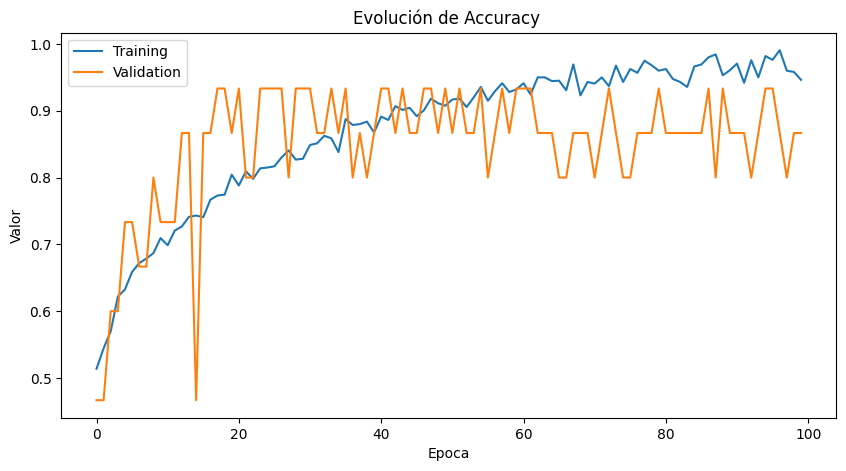

In [47]:
# Graficamos
plt.figure(figsize=(10, 5))
plt.plot(hist.history["accuracy"], label="Training")
plt.plot(hist.history["val_accuracy"], label="Validation")
plt.title("Evolución de Accuracy ")
plt.xlabel("Epoca")
plt.ylabel("Valor")
plt.legend()
plt.show()

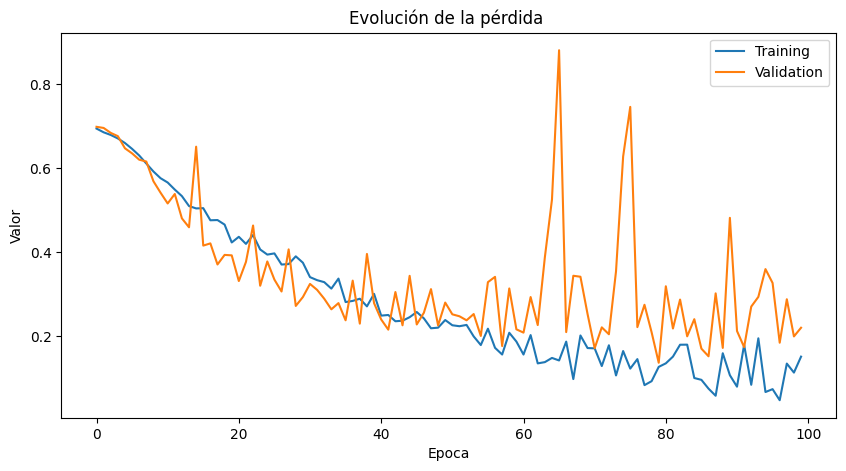

In [48]:
# Graficamos
plt.figure(figsize=(10, 5))
plt.plot(hist.history["loss"], label="Training")
plt.plot(hist.history["val_loss"], label="Validation")
plt.title("Evolución de la pérdida ")
plt.xlabel("Epoca")
plt.ylabel("Valor")
plt.legend()
plt.show()

In [49]:
cat_img = load_image("./cat.jpg")
bun_img = load_image("./conejo.jpg")

cat_img = cat_img.reshape((1, -1))
bun_img = bun_img.reshape((1, -1))

In [50]:
# Predecimos
cat_pred = model.predict(cat_img)
bun_pred = model.predict(bun_img)

print(f"Predicción para el gato: {np.round(cat_pred)}, Certeza: {cat_pred}")
print(f"Predicción para el conejo: {np.round(bun_pred)}, Certeza: {1-bun_pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicción para el gato: [[0.]], Certeza: [[0.33161184]]
Predicción para el conejo: [[0.]], Certeza: [[0.9618398]]


--------------
## Implementacion con modulos

In [54]:
import torch.nn as nn


# Programación explicita.
layers = []

# Configurar las capas intermedias
sizes = [64, 32]

# Primer capa
for output in sizes:
    layers.append(nn.LazyLinear(output))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(0.5))
    
# Output layer
layers.append(nn.LazyLinear(1))
layers.append(nn.Sigmoid())

# Creamos el modelo
model = nn.Sequential(*layers)

# inicialización --- warmup
_ = model(X_testPT)

# 
model

Sequential(
  (0): Linear(in_features=12288, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=32, out_features=1, bias=True)
  (7): Sigmoid()
)

In [55]:
def train_torch(model, train_loader, test_loader, criterion, optimizer, epochs, device=None, verbose=True):
    if not device:
        device = torch.device("cpu")
        model = model.to(device)
        # train_loader = train_loader.to(device)
        test_loader = test_loader.to(device)
        
    all_losses = []
    test_acc_values = []
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        
        for data, target, in train_loader:
            data, target = data.to(device), target.to(device).float()
            
            optimizer.zero_grad()
            y_pred = model(data)
            
            loss = criterion(y_pred, target)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            all_losses.append(total_loss)  
        # inner for
        
        avg_loss = total_loss / len(train_loader)
        
        with torch.no_grad():
            total = 0
            correct = 0
            for data, target in test_loader:
                data, target = data.to(device), target.to(device).float()
                y_pred = model(data)
                
                predictions = (y_pred >= 0.5).float()
                total += target.size(0)
                correct += (predictions == target).sum().item()
                
        test_acc = correct / total
        test_acc_values.append(test_acc)
            
        if verbose:
            print(f"[Epoca {epoch}] Train loss: {avg_loss:.5f} -- Test Acc: {test_acc:.5f}")
            
    return all_losses, test_acc_values             
    
        

In [58]:
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# entrenar
hist = train_torch(model.to(device), train_loader, test_loader, criterion, optimizer, epochs, device, True)

[Epoca 0] Train loss: 0.39964 -- Test Acc: 0.83625
[Epoca 1] Train loss: 0.38104 -- Test Acc: 0.82812
[Epoca 2] Train loss: 0.39365 -- Test Acc: 0.83062
[Epoca 3] Train loss: 0.40135 -- Test Acc: 0.83875
[Epoca 4] Train loss: 0.38088 -- Test Acc: 0.83688
[Epoca 5] Train loss: 0.37849 -- Test Acc: 0.83688
[Epoca 6] Train loss: 0.38514 -- Test Acc: 0.82250
[Epoca 7] Train loss: 0.37226 -- Test Acc: 0.84688
[Epoca 8] Train loss: 0.36599 -- Test Acc: 0.78625
[Epoca 9] Train loss: 0.35546 -- Test Acc: 0.81250
[Epoca 10] Train loss: 0.35521 -- Test Acc: 0.79937
[Epoca 11] Train loss: 0.33763 -- Test Acc: 0.81063
[Epoca 12] Train loss: 0.35849 -- Test Acc: 0.85375
[Epoca 13] Train loss: 0.36067 -- Test Acc: 0.79688
[Epoca 14] Train loss: 0.36921 -- Test Acc: 0.86000
[Epoca 15] Train loss: 0.32900 -- Test Acc: 0.84688
[Epoca 16] Train loss: 0.34392 -- Test Acc: 0.82625
[Epoca 17] Train loss: 0.36869 -- Test Acc: 0.86625
[Epoca 18] Train loss: 0.36448 -- Test Acc: 0.84125
[Epoca 19] Train loss:

In [60]:
# Inferencia
cat_img = load_image("./cat.jpg")
bun_img = load_image("./conejo.jpg")

cat_img_ = torch.tensor(cat_img, dtype=torch.float32).unsqueeze(0)
bun_img_ = torch.tensor(bun_img, dtype=torch.float32).unsqueeze(0)

# Unimos en un único tensor
images = torch.vstack([cat_img_, bun_img_])
images = images.view(images.shape[0], -1)
images.shape
# 64x64x3 -> unsqueeze(0) -> 1x64x64x3 -> 1x12288 -> 2x12288

torch.Size([2, 12288])

In [61]:
model.eval()
model(images.to(device))

tensor([[0.6060],
        [0.0510]], grad_fn=<SigmoidBackward0>)

In [62]:
with torch.no_grad():
    model = model.to(torch.device("cpu"))
    pred = model(images)
pred

tensor([[0.6060],
        [0.0510]])

------
### Keras

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# Crear el modelo
model = Sequential()
# Tamaño de las capas
sizes = [64, 32]
# Input
model.add(layers.Dense(sizes[0], activation="relu", input_shape=(X_testTF.shape[1], )))
model.add(layers.Dropout(0.5))
# Hidden
model.add(layers.Dense(sizes[1], activation="relu"))
model.add(layers.Dropout(0.5))
# Output
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

c:\Users\07020\Dev\curso_ml\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)             ┃ Output Shape       ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense (Dense)            │ (None, 64)         │    786,496 │
├──────────────────────────┼────────────────────┼────────────┤
│ dropout (Dropout)        │ (None, 64)         │          0 │
├──────────────────────────┼────────────────────┼────────────┤
│ dense_1 (Dense)          │ (None, 32)         │      2,080 │
├──────────────────────────┼────────────────────┼────────────┤
│ dropout_1 (Dropout)      │ (None, 32)         │          0 │
├──────────────────────────┼────────────────────┼────────────┤
│ dense_2 (Dense)          │ (None, 1)          │         33 │
└──────────────────────────┴────────────────────┴────────────┘

 Total params: 788,609 (3.01 MB)

 Trainable params: 788,609 (3.01 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
# Compilar y entrenar
model.compile(optimizer=SGD(learning_rate=0.01),
              loss="binary_crossentropy",
              metrics=["accuracy", "precision"])

hist = model.fit(X_trainTF,
                 y_trainTF,
                 epochs=epochs,
                 batch_size=32,
                 validation_data=(X_testTF, y_testTF))

# Evaluación
loss, accuracy, pres = model.evaluate(X_testTF, y_testTF)
print(f"Loss: {loss:.4f} -- Accuracy: {accuracy*100:.4f} -- Pres: {pres:.4f}")

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5033 - loss: 0.7347 - precision: 0.4831 - val_accuracy: 0.6000 - val_loss: 0.6831 - val_precision: 1.0000
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5428 - loss: 0.6845 - precision: 0.5531 - val_accuracy: 0.5333 - val_loss: 0.6906 - val_precision: 1.0000
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5592 - loss: 0.6851 - precision: 0.5705 - val_accuracy: 0.8667 - val_loss: 0.6129 - val_precision: 0.8333
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5535 - loss: 0.6790 - precision: 0.5782 - val_accuracy: 0.7333 - val_loss: 0.6008 - val_precision: 0.8750
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6067 - loss: 0.6584 - precision: 0.5972 - val_accuracy: 0.8000 - val_loss: 0.6028 - val_precision: 0.7692
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6182 - loss: 0.6324 - precision: 0.6022 - val_accuracy: 0.8667 - val_loss: 0.5809 - v

In [66]:
cat_img = load_image("./cat.jpg")
bun_img = load_image("./conejo.jpg")

cat_img = cat_img.reshape((1, -1))
bun_img = bun_img.reshape((1, -1))

images = np.vstack([cat_img, bun_img]) # 2x12288

images.shape

(2, 12288)

In [67]:
model.predict(images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


array([[0.4422369 ],
       [0.05835333]], dtype=float32)